## Import Modules

In [2]:
!pip3 install gymnasium xgboost stable-baselines3 stable-baselines3[extra] tqdm rich

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 5.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 2.4 MB/s eta 0:00:00a 0:00:01
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 4.8 MB/s eta 0:00:0000:0100:01
  Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 30.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 5.8 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#!pip3 install gymnasium
#!pip3 install xgboost
#!pip3 install stable-baselines3
#!pip3 install stable-baselines3[extra]
#!pip3 install tqdm
#!pip3 install rich
#!pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --user

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#os.environ["WORLD_SIZE"] = "1"
import argparse
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import xgboost as xgb
import os
import pickle

print('Cuda available:', torch.cuda.is_available())

from tqdm import tqdm
from gymnasium import spaces
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from stable_baselines3 import PPO
from torch.utils.data import Dataset
from torch.utils.tensorboard.writer import SummaryWriter 


/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cuda available: False


## Set constants (change if needed)

In [3]:
NUM_FEATS_T1 = 65
NUM_FEATS_T2 = 512
NUM_FEATS_T3 = 64
NUM_FEATS_T4 = 256

NUM_FEATURES = 16  # How many of the top features to select for feature reduction

DATA_PATH = os.path.join('../output/fusion_data', 'combined_features_allsecond_to_last.npy')  # Expects file containing numpy array of shape (num_samples, num_features)
LABELS_PATH = os.path.join('../output/fusion_data', 'labels.npy')  # Expects file containing numpy array of shape (num_samples, num_classes)

sig_types = [['2-ASK', ['ask', 2], 0],
             ['4-ASK', ['ask', 4], 1],
             ['8-ASK', ['ask', 8], 2],
             ['BPSK', ['psk', 2], 3],
             ['QPSK', ['psk', 4], 4],
             ['16-QAM', ['qam', 16], 5],
             ['Tone', ['constant'], 6],
             ['P-FMCW', ['p_fmcw'], 7]]
num_classes = len(sig_types)

## Load data

In [4]:
data = torch.from_numpy(np.load(DATA_PATH))
labels = torch.from_numpy(np.load(LABELS_PATH))

## Set up helper functions/classes

In [5]:
# These functions are from team 2's old code

def get_reward(train_data, train_labels, validation_data, validation_labels):
    clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, n_estimators=5)
    clf.fit(train_data, train_labels, eval_set=[(validation_data, validation_labels)], verbose=0)

    return np.sum(clf.predict(validation_data) == validation_labels) / validation_labels.shape[0]

def statistical_feature_selection(data, labels):
    rewards = {}
    curr_features = np.arange(data.shape[1])
    curr_data = data
    for n in [data.shape[1], 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]:
    #for n in [1, 2, 4, 8, 16]:
        curr_data = curr_data[:, curr_features]
        train_data, validation_data, train_labels, validation_labels = train_test_split(np.array(curr_data, dtype=np.float32), np.array(labels, dtype=np.int32), test_size=0.2)

        selector = RFE(DecisionTreeClassifier(), n_features_to_select=n, step=100, verbose=1)
        selector = selector.fit(train_data, train_labels)

        clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
        clf.fit(train_data[:,selector.support_], train_labels, eval_set=[(validation_data[:,selector.support_], validation_labels)], verbose=0)
        
        model_out = np.argmax(clf.predict(validation_data[:, selector.support_]), axis=1)
        num_correct = np.sum(model_out == np.argmax(validation_labels, axis=1))
        num_validation_labels = validation_labels.shape[0]
        acc = num_correct / num_validation_labels
        

        rewards[n] = acc
        curr_features = selector.support_

    sns.lineplot(rewards)
    plt.title("Accuracy of XGBoost vs number of features")
    plt.xlabel("Number of Features")
    plt.ylabel("Accuracy")

class FusionModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.layers = nn.Sequential(
                nn.LazyLinear(1024),
                nn.ReLU(),
                nn.Linear(1024, 256),
                nn.ReLU(),
                nn.Linear(256, self.num_classes)
        )

    def forward(self, x):
        return self.layers(x)

class FusionDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
class SensorFusionBestFeatureDatasetEnv(gym.Env):
    def __init__(self, data, labels, num_classes, n, save_clf=True, load_clf=False):
        self.data = np.array(data)
        self.labels = np.array(labels)
        self.n = n
        self.mask_value = -100000

        self.observation_space = spaces.MultiDiscrete([self.data.shape[1]] * self.n)
        self.action_space = spaces.Discrete(self.data.shape[1])

        train_data, validation_data, train_labels, validation_labels = train_test_split(self.data, self.labels, test_size=0.2)
        self.train_data = train_data
        self.train_labels = train_labels.astype(int)
        self.validation_data = validation_data
        self.validation_labels = validation_labels.astype(int)

        self.curr_reward = 0
        self.prev_reward = 0
        
        self.clf = None

    def extract_important_features_using_decision_tree(self):
        clf = RandomForestClassifier(n_estimators=100, verbose=1)
        clf.fit(self.train_data, self.train_labels)

        return clf.feature_importances_.argsort()[-self.n:]

    def mask_data(self, data, idxes):
        mask = np.ones(data.shape, dtype=bool)
        for i in range(mask.shape[0]):
            mask[i][idxes[i]] = 0
        data[mask] = self.mask_value
        return data

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.count = 0
        self.action_idxes = np.ones(self.n, dtype=int)

        return self.action_idxes, {}
    
    def step(self, action):
        if action in self.action_idxes:
            return self.action_idxes, 0, False, False, {}

        if self.count < self.n:
            self.action_idxes[self.count] = action
        else:
            self.action_idxes[np.random.randint(self.n)] = action

        accuracy = self.calculate_accuracy(self.action_idxes)

        self.count += 1
        if self.count == self.n:
            terminated = True
        else:
            terminated = False
    
        return self.action_idxes, accuracy, terminated, False, {}

    def calculate_accuracy(self, action_idxes):

        train_data = self.train_data[:, action_idxes]
        validation_data = self.validation_data[:, action_idxes]
    
        self.clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, n_estimators=5)
        self.clf.fit(train_data, self.train_labels, eval_set=[(validation_data, self.validation_labels)], verbose=0)

        model_out = np.argmax(self.clf.predict(validation_data), axis=1)
        num_correct = np.sum(model_out == np.argmax(self.validation_labels, axis=1))
        num_validation_labels = self.validation_labels.shape[0]
        acc = num_correct / num_validation_labels
        #print(acc)
        return acc

    def render(self):
        return

    def close(self):
        return

class FeatureSelectionModel(nn.Module):
    def __init__(self, n, num_features, env, epsilon=0.999, epsilon_decay=0.001):
        self.n = n
        self.num_features = num_features
        self.env = env
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.episode = 0

        self.AOR = np.zeros(num_features)
        self.AOR_counts = np.zeros(num_features)

    def decay_epsilon(self):
        if self.episode > 1500:
            self.epsilon = max(self.epsilon - self.epsilon_decay, 0.0)
        elif self.episode > 500:
            self.epsilon = max(self.epsilon - self.epsilon_decay, 0.1)

    def update_AOR(self, action, reward):
        self.AOR[action] = (self.AOR[action] * self.AOR_counts[action] + reward) / (self.AOR_counts[action] + 1)
        self.AOR_counts[action] += 1

    def select_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.choice(np.arange(self.num_features))
        mask = np.zeros(self.AOR.shape)
        mask[state] = True
        return ma.array(np.copy(self.AOR), mask=mask).argmax()

    def learn(self, episodes=16):
        writer = SummaryWriter(f"runs/n_{self.n}_episodes_{episodes}")
        for ep in tqdm(range(episodes)):
            rewards = []
            terminated = False
            state, _ = self.env.reset()
            while not terminated:
                self.decay_epsilon()
    
                action = self.select_action(state, self.epsilon)
    
                state, reward, terminated, _, _ = env.step(action)
                rewards.append(reward)
                self.update_AOR(action, reward)
            writer.add_scalar('reward', rewards[-1], ep)
            writer.add_scalar('epsilon', self.epsilon, ep)
            self.episode += 1

def visualize_output_features(d, l, nc):
    feature_avgs = torch.stack([d[l.int()==i].mean(axis=0) for i in range(nc)])
    plt.figure(0, (15, 1))
    sns.heatmap(feature_avgs)
    plt.yticks(ticks=np.arange(nc) + 0.5, labels=['2-ASK', '4-ASK', '8-ASK', 'BPSK', 'QPSK', '16-QAM', 'Tone', 'P-FMCW'], rotation=0)
    plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

def run_eval(num_episodes, policy):
    rewards = []
    for _ in tqdm(range(num_episodes)):
        obs, _ = env.reset()
        ep_rewards = []
        ep_actions = []
        terminated = False
        while not terminated:
            action = policy(obs)
            _, reward, terminated, _, _ = env.step(action)
            ep_rewards.append(reward)
            ep_actions.append(action)
        rewards.append(ep_rewards[-1])
    return np.mean(rewards)

## Create the RL fused model

In [6]:
env = SensorFusionBestFeatureDatasetEnv(data, labels, num_classes, NUM_FEATURES)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

env.reset()
model = PPO("MlpPolicy", env, verbose=1, batch_size=16, n_steps=64, device=device)
model.learn(total_timesteps=4096, progress_bar=False)
avg_model_rewards = run_eval(10, lambda obs: model.predict(obs)[0])
print(f"Average rewards for RL agent: {avg_model_rewards}")
print('RL Accuracy:', env.calculate_accuracy(env.action_idxes))

# Save the trained model
env.clf.save_model('../data/summer_models/rl_fused_2tl.json')

# Save a list of the top contributing features we found
with open('../data/summer_models/rl_feature_idxes_2tl.pkl', 'wb') as f:
    pickle.dump(env.action_idxes, f)

cpu
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


AxisError: axis 1 is out of bounds for array of dimension 1

## Create the RFE fused model

In [6]:
train_data, validation_data, train_labels, validation_labels = train_test_split(np.array(data, dtype=np.float32), np.array(labels, dtype=np.int32), test_size=0.2)
        
selector = RFE(DecisionTreeClassifier(), n_features_to_select=NUM_FEATURES, step=100, verbose=1)
selector = selector.fit(train_data, train_labels)
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
clf.fit(train_data[:,selector.support_], train_labels, eval_set=[(validation_data[:,selector.support_], validation_labels)], verbose=0)
model_out = np.argmax(clf.predict(validation_data[:, selector.support_]), axis=1)
num_correct = np.sum(model_out == np.argmax(validation_labels, axis=1))
num_validation_labels = validation_labels.shape[0]
acc = num_correct / num_validation_labels
print('RFE Accuracy:', acc)

# Save the trained model
clf.save_model('../data/summer_models/rfe_fused_2tl.json')

# Get the list of features selected using RFE
rfe_selected_feats = [i for i, x in enumerate(selector.support_) if x]

# Save the list of features
with open('../data/summer_models/rfe_feature_idxes_2tl.pkl', 'wb') as f:
    pickle.dump(rfe_selected_feats, f)
        

Fitting estimator with 897 features.
Fitting estimator with 797 features.
Fitting estimator with 697 features.
Fitting estimator with 597 features.
Fitting estimator with 497 features.
Fitting estimator with 397 features.
Fitting estimator with 297 features.
Fitting estimator with 197 features.
Fitting estimator with 97 features.
RFE Accuracy: 0.9970476190476191


RFE: 0.998
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 0   |
|    iterations      | 1   |
|    time_elapsed    | 119 |
|    total_timesteps | 64  |
----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 0          |
|    iterations           | 2          |
|    time_elapsed         | 224        |
|    total_timesteps      | 128        |
| train/                  |            |
|    approx_kl            | 0.02048681 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.8       |
|    explained_variance   | -0.00482   |
|    learning_rate        | 0.0003     |
|    loss                 | 25.1       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0617    |
|    value_loss           | 66.7   

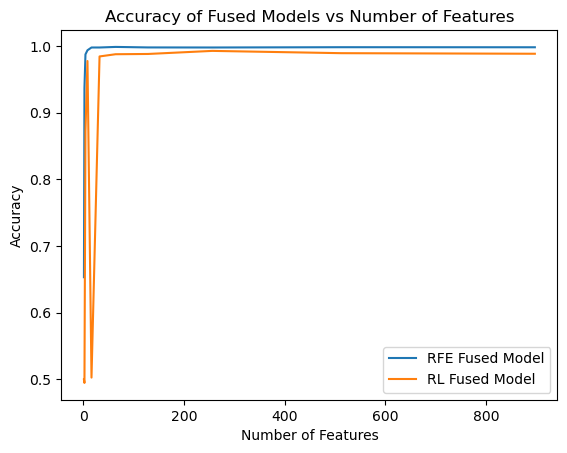

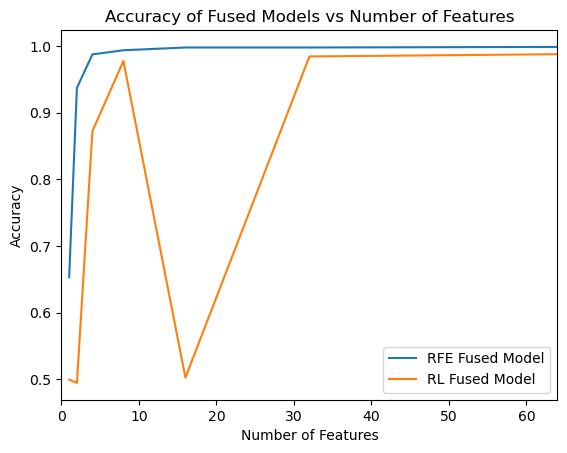

In [7]:
accuracies_rfe = {}
accuracies_rl = {}
curr_features = np.arange(data.shape[1])
curr_data = data
    
num_feats_to_test = [data.shape[1], 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
    
for n in num_feats_to_test:
    curr_data = curr_data[:, curr_features]
    train_data, validation_data, train_labels, validation_labels = train_test_split(np.array(curr_data, dtype=np.float32), np.array(labels, dtype=np.int32), test_size=0.2)
        
    selector = RFE(DecisionTreeClassifier(), n_features_to_select=n, step=100, verbose=1)
    selector = selector.fit(train_data, train_labels)
    clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
    clf.fit(train_data[:,selector.support_], train_labels, eval_set=[(validation_data[:,selector.support_], validation_labels)], verbose=0)
    model_out = np.argmax(clf.predict(validation_data[:, selector.support_]), axis=1)
    num_correct = np.sum(model_out == np.argmax(validation_labels, axis=1))
    num_validation_labels = validation_labels.shape[0]
    acc = num_correct / num_validation_labels
    accuracies_rfe[n] = acc
    print('RFE:', acc)
    curr_features = selector.support_
        
    env = SensorFusionBestFeatureDatasetEnv(data, labels, num_classes, n)
    env.reset()
    model = PPO("MlpPolicy", env, verbose=1, batch_size=16, n_steps=64)
    model.learn(total_timesteps=128, progress_bar=False)
    acc = env.calculate_accuracy(env.action_idxes)
    accuracies_rl[n] = acc
    print('RL:', acc)
    
df = pd.DataFrame(np.array(num_feats_to_test).T, columns=['num_feats'])
accuracies_rfe_list = []
accuracies_rl_list = []
for feat in num_feats_to_test:
    accuracies_rfe_list.append(accuracies_rfe[feat])
    accuracies_rl_list.append(accuracies_rl[feat])
df.loc[:, 'RFE Fused Model'] = np.array(accuracies_rfe_list).T
df.loc[:, 'RL Fused Model'] = np.array(accuracies_rl_list).T
    
# Plot accuracy for all features
df.plot(x='num_feats')
plt.title("Accuracy of Fused Models vs Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
#plt.savefig('../data/fusion_plots/fused_model_accuracy/fused_accuracies_2tl_all.png')
plt.show()
    
# Plot accuracy up to 64 features
df.plot(x='num_feats')
plt.xlim([0, 64])
plt.title("Accuracy of Fused Models vs Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
#plt.savefig('../data/fusion_plots/fused_model_accuracy/fused_accuracies_2tl_64.png')
plt.show()

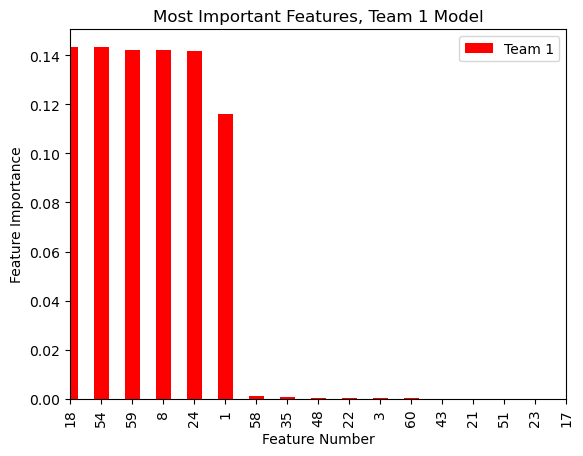

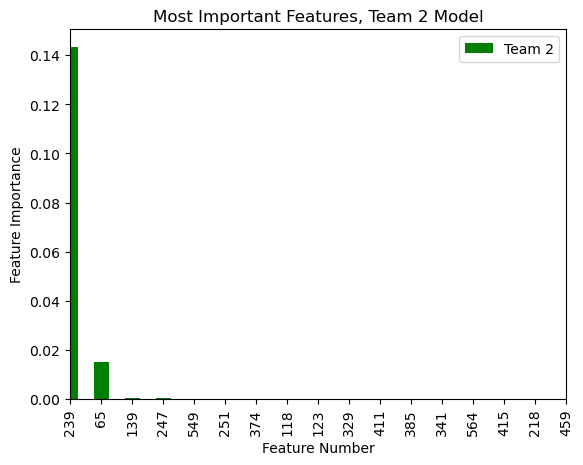

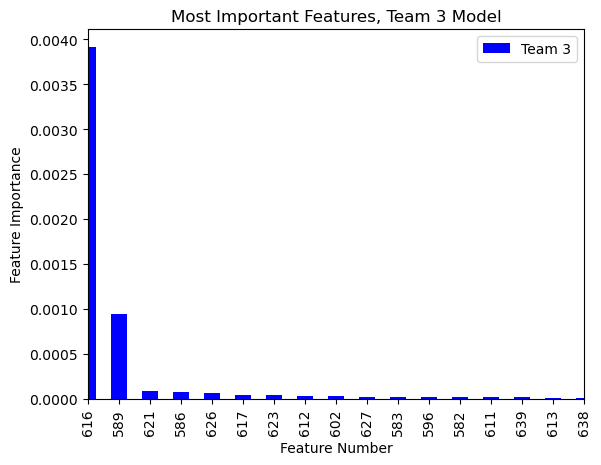

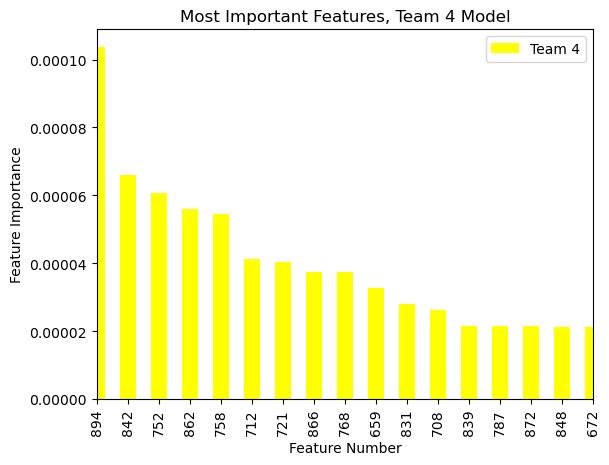

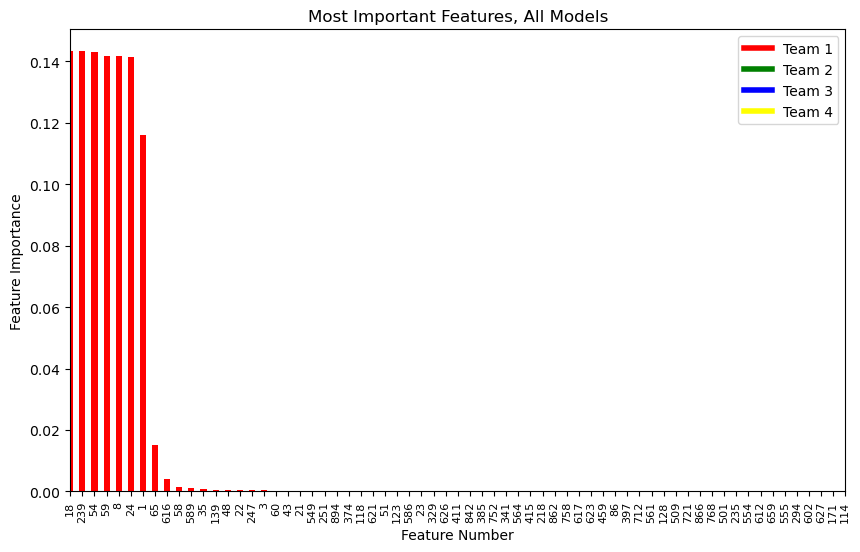

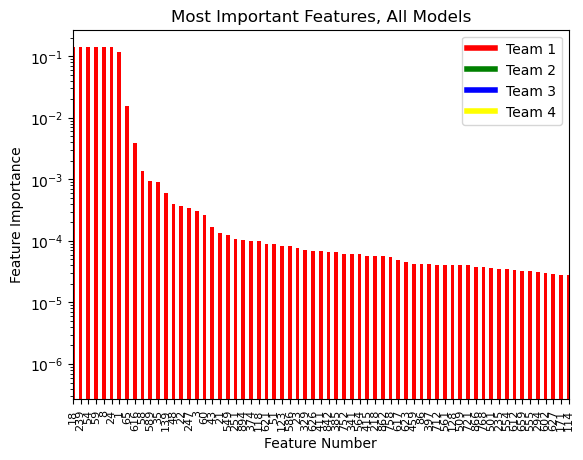

In [8]:
model = DecisionTreeClassifier()
model.fit(data, labels)
importances = model.feature_importances_
importances = np.array(importances)
df = pd.DataFrame(importances.T, columns=['Feature Importance'])
    
team_nums = []
team_nums.extend(['Team 1'] * NUM_FEATS_T1)
team_nums.extend(['Team 2'] * NUM_FEATS_T2)
team_nums.extend(['Team 3'] * NUM_FEATS_T3)
team_nums.extend(['Team 4'] * NUM_FEATS_T4)
df.loc[:, 'Team'] = team_nums
    
df = df.sort_values(['Feature Importance'], ascending=[False])
df = df.reset_index()
df = df.rename(columns={'index':'Feature Number'})
df_team1 = df.loc[df['Team'] == 'Team 1']
df_team1 = df_team1.rename(columns={'Feature Importance':'Team 1'})
df_team2 = df.loc[df['Team'] == 'Team 2']
df_team2 = df_team2.rename(columns={'Feature Importance':'Team 2'})
df_team3 = df.loc[df['Team'] == 'Team 3']
df_team3 = df_team3.rename(columns={'Feature Importance':'Team 3'})
df_team4 = df.loc[df['Team'] == 'Team 4']
df_team4 = df_team4.rename(columns={'Feature Importance':'Team 4'})
    
# Plot team 1's top 16 features
df_team1.plot.bar(x='Feature Number', color='red')
plt.ylabel('Feature Importance')
plt.title('Most Important Features, Team 1 Model')
plt.xlim([0, 16])
plt.show()
#plt.savefig('../data/fusion_plots/feature_importances/team1_2tl_feature_importance.png')

# Plot team 2's top 16 features
df_team2.plot.bar(x='Feature Number', color='green')
plt.ylabel('Feature Importance')
plt.title('Most Important Features, Team 2 Model')
plt.xlim([0, 16])
plt.show()
#plt.savefig('../data/fusion_plots/feature_importances/team2_2tl_feature_importance.png')

# Plot team 3's top 16 features
df_team3.plot.bar(x='Feature Number', color='blue')
plt.ylabel('Feature Importance')
plt.title('Most Important Features, Team 3 Model')
plt.xlim([0, 16])
plt.show()
#plt.savefig('../data/fusion_plots/feature_importances/team3_2tl_feature_importance.png')

# Plot team 4's top 16 features
df_team4.plot.bar(x='Feature Number', color='yellow')
plt.ylabel('Feature Importance')
plt.title('Most Important Features, Team 4 Model')
plt.xlim([0, 16])
plt.show()
#plt.savefig('../data/fusion_plots/feature_importances/team4_2tl_feature_importance.png')

# Plot the top 64 features from all models
# NOTE: I couldn't figure out how to color bars based on which team's model they came from
# With the current implementation, the bars need to be manually recolored, referencing the number of features extracted from each team's model
# For example, with 65 feats from team 1, 512 from team 2, 64 from team 3, and 256 from team 4 (total of 897 feats), the breakdown is as follows:
# Team 1: Feats 0 through 64
# Team 2: Feats 65 through 576
# Team 3: Feats 577 through 640
# Team 4: Feats 641 through 896
 
# Linear y axis
figure(figsize=(10, 6))
ax = plt.subplot(111)
df.plot.bar(x='Feature Number', color='red', ax=ax)
plt.xlim([0, 64])
ax.tick_params(axis='x', which='major', labelsize=8)
ax.tick_params(axis='x', which='minor', labelsize=6)
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='yellow', lw=4)]
ax.legend(custom_lines, ['Team 1', 'Team 2', 'Team 3', 'Team 4'])
plt.ylabel('Feature Importance')
plt.title('Most Important Features, All Models')
plt.yscale('linear')
plt.show()
#plt.savefig('../data/fusion_plots/feature_importances/all_models_2tl_feature_importance_lin.png')

# Logarithmic y axis
ax = plt.subplot(111)
#figure(figsize=(10, 6))
df.plot.bar(x='Feature Number', color='red', ax=ax)
plt.xlim([0, 64])
ax.tick_params(axis='x', which='major', labelsize=8)
ax.tick_params(axis='x', which='minor', labelsize=6)
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='yellow', lw=4)]
ax.legend(custom_lines, ['Team 1', 'Team 2', 'Team 3', 'Team 4'])
plt.ylabel('Feature Importance')
plt.title('Most Important Features, All Models')
plt.yscale('log')
plt.show()
#plt.savefig('../data/fusion_plots/feature_importances/all_models_2tl_feature_importance_log.png')